# Gotchas and Optimization

Working with computers brings some occupational hazards, especially when things don't work the way one might expect. **These problems are not specific to Python. They are fundamental challenges that come from using numbers in a computer.** 

There are also some non-obvious ways to significantly improve the performance of computations - this file examines some of these in more detail.

By the end of this file you should have seen simple examples of:  

1. Unavoidable errors
   - Floating point small remainders
   - Floating point loss of precision
   - Floating point catastrophic cancellation
   - Integer overflow
2. Optimization
   - Vectorization





Further reading:

1. https://docs.scipy.org/doc/  
2. http://docs.oracle.com/cd/E19957-01/806-3568/ncg_goldberg.html  
3. https://docs.python.org/3/tutorial/floatingpoint.html  


## Numbers in a Computer

Information in a computer uses memory and storage, and due to emperical limitations in the size of these two resources, there is a finite amount of precision that is typically used. From the numpy documentation at https://docs.scipy.org/doc/numpy/user/basics.types.html, a variety of formats are available: 

`Data type 	Description
bool_ 	Boolean (True or False) stored as a byte
int_ 	Default integer type (same as C long; normally either int64 or int32)
intc 	Identical to C int (normally int32 or int64)
intp 	Integer used for indexing (same as C ssize_t; normally either int32 or int64)
int8 	Byte (-128 to 127)
int16 	Integer (-32768 to 32767)
int32 	Integer (-2147483648 to 2147483647)
int64 	Integer (-9223372036854775808 to 9223372036854775807)
uint8 	Unsigned integer (0 to 255)
uint16 	Unsigned integer (0 to 65535)
uint32 	Unsigned integer (0 to 4294967295)
uint64 	Unsigned integer (0 to 18446744073709551615)
float_ 	Shorthand for float64.
float16 	Half precision float: sign bit, 5 bits exponent, 10 bits mantissa
float32 	Single precision float: sign bit, 8 bits exponent, 23 bits mantissa
float64 	Double precision float: sign bit, 11 bits exponent, 52 bits mantissa
complex_ 	Shorthand for complex128.
complex64 	Complex number, represented by two 32-bit floats (real and imaginary components)
complex128 	Complex number, represented by two 64-bit floats (real and imaginary components)`


Note that for the `int` and `uint`, there's a fundamental limitation to the range of values available. **For example, `uint8` can only store integers from 0 to 255 - no other numbers can be used.** It uses less memory and/or storage to save a number than `uint16` or `uint32`.

Floats are another common example - they store a number in scientific notation, and are useful for decimal numbers. **Often, floating point numbers are used for all calculations, but are not always needed, may occupy more memory than is needed, and can introduce errors into certain calculations.**



In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# The memory consumption of different types of variables can vary significantly:

num_int = np.array(4, dtype='int8')
print("Memory (bytes) used by the int8 is: ", num_int.nbytes)

num_float = np.array(4, dtype='float')
print("Memory (bytes) used by the float is: ", num_float.nbytes)

Memory (bytes) used by the int8 is:  1
Memory (bytes) used by the float is:  8


Multiply these values by large matricies, and it becomes a bit more clear why some data types might be more practical than others for a given application.

## Unavoidable errors

### Floating point errors: small remainders 

Frequently, the inablility to store a perfect number (i.e. 1/3, which has 0.333 repeating) leads to small bits leftover from calculations:

In [3]:
var_1 = (0.1 + 0.1 + 0.1) - 0.3
print(var_1)

5.551115123125783e-17


This comes up frequently when applying logic to floating point arithmetic:

In [4]:
1 - 0.7 == 0.3

False

Scaling the numbers can sometimes help. It's almost never a good idea to work in such small numeric ranges:

In [29]:
# Scaling can sometimes help
1*10 - 0.7*10 == 0.3*10

True

### Floating point errors: loss of precision

Some numbers simply can't be represented perfectly, so when two numbers of very different sizes are used, precision may be lost:

In [6]:
var1 = 1/3*10**18  # Start with a large number
var2 = 1          
var3 = var1+var2 # Add a small number

print(var3 - var1)# When subtracting a large number from a similarly large number, the smaller number is ignored

0.0


### Floating point errors: catastrophic cancellation

Frequently, when operations increase the relative error more than the absolute error, unexpected behavior can occur.

In [7]:
var1 = np.array(0.9876543210987654)
var2 = np.array(0.9876543210987653)

var3 = var1 - var2
print(var3)

1.11022302463e-16


In [8]:
exp_val = 1e-16
rel_error = (var3 - exp_val)/exp_val
print("The relative error is {0:.2g}%".format(rel_error*100))

The relative error is 11%


There are mathematical operations where this becomes significantly more problematic. While it may be possible to work around by avoiding the exact representation of those numbers, in general, different algorithms are needed for a solution.

As an example, consider: the mathematically equivalent relations:

$ y_1(x) = 2^{-x} - \frac{1}{1+2^x} $  
and  
$ y_2(x) = \frac{2^{-x}}{1+2^x} $  

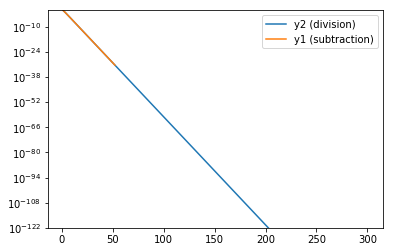

In [9]:
X = np.linspace(1,300,300)
y1 = 2**(-X)-1/(1+2**(X))
y2 = 2**(-X)/(1+2**(X))

# Plot
plt.semilogy(X,y2, label='y2 (division)')
plt.semilogy(X,y1, label='y1 (subtraction)')
plt.ylim(1e-122, y1.max())
plt.legend(loc='best')
plt.show()

Here, it can be shown that the subtraction is a catastrophic cancellation, while division and multiplication doesn't suffer the same fate. Using:

$ a = 2^{-x} $  
and   
$ b = \frac{1}{1+2^x} $  

We can compare the two different operations as:  
$ y1(x) = a - b $  
$ y2(x) = \frac{a}{b}$   

In [10]:
# Using the 53rd index (53) as a point to check the difference:
a = 2**(-X[53])
print("a ( 2^-x ) for x = 53 is: {}".format(a))
b = 1/(1+2**(X[53]))
print("b ( 1/(1+2^x) ) for x = 53 is: {}".format(b))

a ( 2^-x ) for x = 53 is: 5.551115123125783e-17
b ( 1/(1+2^x) ) for x = 53 is: 5.551115123125783e-17


The subtraction of the two similar numbers gives a zero result, resulting in a significant loss in precision (i.e. absolute error of infinity).

## Integer Overflow

When using integers in the Python scientific stack (numpy, pandas), it is possible for a simple arithmetic to cause the values to 'wrap around' or become negative.

In [16]:
x = 2**63 - 1       # Python uses 'int'
x_np = np.array(x)  # numpy automatically assigns to 'int64'
x_pd = pd.Series(x) # pandas automatically assigns to 'int64'
print(x)
print(x_np)
print(x_pd[0])

9223372036854775807
9223372036854775807
9223372036854775807


If we add one to the sum, we can get pretty different results when using the Python scientific stack (numpy, pandas):

In [12]:
print("The python sum is:  ", x+1)
print("The numpy sum is:   ", x_np+1)
print("The pandas sum is:  ", x_pd[0]+1)

The python sum is:   9223372036854775808
The numpy sum is:    -9223372036854775808
The pandas sum is:   -9223372036854775808


//anaconda/envs/intro_sci_py3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: overflow encountered in long_scalars
  app.launch_new_instance()


Python integers have arbitrary precision, so the integer sum comes out as expected. **In the scientific python stack, the C-style fixed-precision integers actually wrap around to negative numbers when increased.**

# Optimization

### Vectorization

For calculations that involve many steps, often a specific step is repeated. Often, this can be reformulated in a way that computers can do far more efficiently - via matrix math. **Reformulating a computation from element-wise operations to array operations is known as vectorization.**

In [13]:
randArr = np.random.rand(10000)

def scaleLoop(array): # For loop goes through each element and adds one
    for i in range(len(array)):
        array[i] = array[i]+1
    return array

%timeit forloopsum = scaleLoop(randArr)

100 loops, best of 3: 3.72 ms per loop


In [14]:
%timeit vectorsum = randArr + 1 # Numpy was written to perform vectorized operations

The slowest run took 41.75 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 5.11 µs per loop


The difference is more than an order of magnitude, although the mileage may vary depending on the computer.